# Objectif du script :

Le script va tout d'abord importer tous les modèles crées jusque là : 
- Modèles A : modèles basés sur les bases DVF + compléments : modèle qui va prédire le prix de base
- Modèles B : modèles basés sur les annonces scrapées : modèle qui va prédire un bonus / malus en fonction des propriétés du bien

Le script va ensuite prendre en input les propriétés d'une annonce et les transformer pour calculer les inputs des modèles

Le script va enfin prédire le prix final recommandé du bien avec la formule suivante
prix_final = prix issu du modèle A + bonus ou malus issu du modèle B


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

from joblib import load

In [2]:
# Applique-t-on le bonus/malus ?
application_bonus = 0    # On décide de le désactiver car les résultats ne sont pas OK
                         # La prédiction ne sera alors basée que sur le modèle A
                         # Il est toutefois possible de l'activer pour voir ce que cela donne

Exemple d'annonce : https://www.superimmo.com/annonces/achat-maison-100m-saint-hilaire-31410-xn1esj

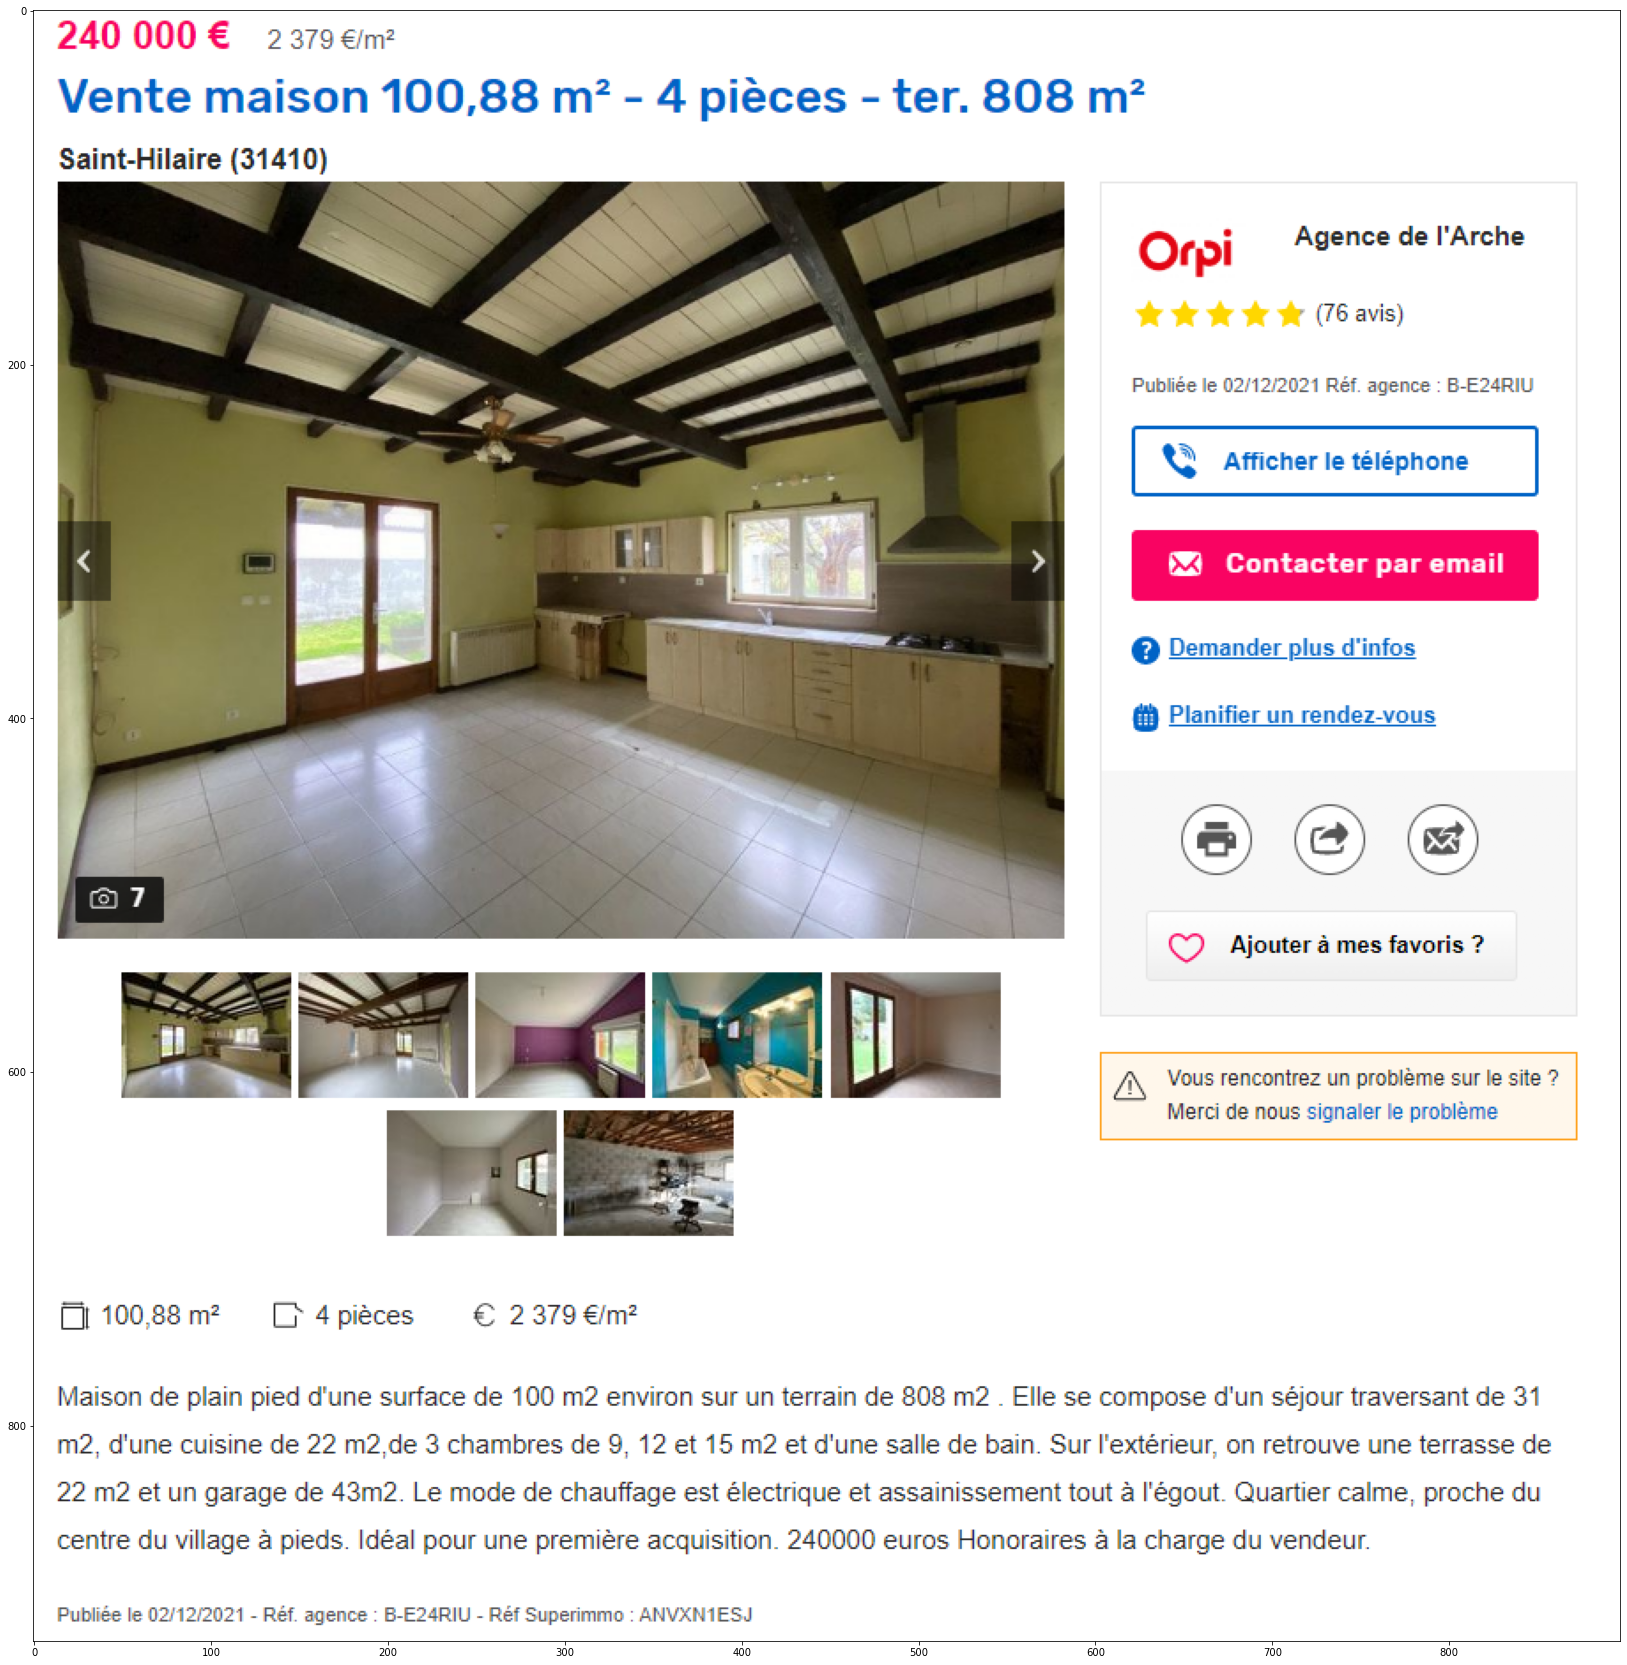

In [3]:
image = img.imread('models/demo.png')
plt.figure(figsize = (40,30))
plt.imshow(image)
plt.show()

In [4]:
# Renseigner ici les propriétés du bien

prix_annonce = 240000

# Emplacement du bien
num_et_rue = "Avenue de Gascogne"                # possible de ne mettre qu'un nom de rue
cp = 31410
ville = "Saint Hilaire"

type_local = 1
surface_terrain = 898
surface = 101
type_local = 1              # 0 si appartement, 1 si maison
nb_pieces = 4
nb_chambres = 3             # Sera utilisé dans prédiction du Bonus / Malus
paris = 0
mer = 0
anciennete = 21
conso_energie = 253
estim_ges = 8

# Features pour prédiction Bonus / Malus
Exposition_Sud = 0
Lumineux = 0
Calme = 1
Volume =  0
Standing = 0
Charme = 0
Mezzanine =  0
Avec_Ascenseur = 0
Sans_Ascenseur = 0
Duplex = 0
Dernier_etage = 0 
Premier_etage = 0
Deuxieme_etage = 0
Troisieme_etage = 0
Quatrieme_etage = 0
Cinquieme_etage = 0
Sixieme_etage = 0
Septieme_etage = 0
Huitieme_etage = 0
RDC = 0
Design = 0
Terrasse = 0
Parfait_etat = 0
Travaux = 0
Proche_commodites = 0
Vue_degagee = 0
Securise = 0
Emplacement = 0
Atypique = 0
Nature = 1
Meuble = 0
Cave = 0
Parking = 0
Cuisine_americaine = 0
Investissement_locatif = 0
Proche_ecoles = 0
Dressing = 0
Plain_Pied = 1
Garage = 0
Grange = 0
Buanderie = 0
Dependance = 0

# Prédiction du prix de base

In [5]:
# Chargement des modèles A
model_A_all = load('models/model_rf_all.pkl')
model_A_appart_province = load('models/model_rf_1_appart_province.pkl')
model_A_appart_paris = load('models/model_rf_2_appart_paris.pkl')
model_A_maison_province = load('models/model_rf_3_maison_province.pkl')

C:\Users\olivier\anaconda\envs\py39\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\olivier\anaconda\envs\py39\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
# Chargement de la liste des features requis pour faire tourner le modèle
df_feat = pd.read_csv('models/features_list_for_model_A.csv', index_col = 0)


In [7]:
from geopy.geocoders import Nominatim

adresse = num_et_rue + " " + str(cp) + " " + ville
code_dep = str(cp)[0:2]
# code_insee = ??

geolocator = Nominatim(user_agent="pyPredImmo")

try:
    location = geolocator.geocode(adresse, country_codes = 'fr', timeout = 5)
    lon = round(location.longitude, 2)
    lat = round(location.latitude, 2)
    print(adresse + " ===> " + str(lat) + "," + str(lon))

except:
    print('L\'adresse du bien n\'a pas été trouvée')

Avenue de Gascogne 31410 Saint Hilaire ===> 43.42,1.27


In [8]:
prix_m2_commune = pd.read_csv('models/prix_m2_commune.csv', dtype = {'Code postal': int})
prix_m2_gps = pd.read_csv('models/prix_m2_gps.csv')

In [9]:
# Identification du prix m2 de la commune
prix_m2_commune_bien = prix_m2_commune[(prix_m2_commune['Code postal'] == cp) & (prix_m2_commune['Type local'] == "Maison")]
prix_m2_commune_bien_val = prix_m2_commune_bien['Prix m2'].iloc[0]
prix_m2_commune_bien_val

2205.378881987577

In [10]:
# Identification du prix m2 du bloc GPS
prix_m2_gps_bien = prix_m2_gps[(prix_m2_gps['lon_2'] == lon) & (prix_m2_gps['lat_2'] == lat) & (prix_m2_gps['Type local'] == "Maison")]
prix_m2_gps_bien_val = prix_m2_gps_bien['Prix m2'].iloc[0]
prix_m2_gps_bien_val

2539.406779661017

In [11]:
# Recherche du loyer, population et revenus
df_other_feat = pd.read_csv('models/loy_rev_pop.csv', dtype = {'Code postal': int}, index_col = 0)
df_other_feat_bien = df_other_feat[(df_other_feat['Code postal'] == cp) & (df_other_feat['Type local'] == "Maison")]
df_other_feat_bien

,Code postal,Commune,Type local,loyer,Population totale,SNHMO18,SNHMFO18
105464,31410,LAVERNOSE-LACASSE,Maison,8.475765,3233.0,11.523062,10.05623
105465,31410,MAUZAC,Maison,8.497115,1314.0,11.523062,10.05623
105467,31410,NOE,Maison,8.864375,2968.0,11.523062,10.05623
105489,31410,CAPENS,Maison,8.497115,685.0,11.523062,10.05623
105492,31410,ST HILAIRE,Maison,8.497115,1302.0,11.523062,10.05623
105553,31410,LONGAGES,Maison,8.497115,3137.0,11.523062,10.05623
105592,31410,MONTAUT,Maison,8.497115,520.0,11.523062,10.05623
105669,31410,LE FAUGA,Maison,8.917463,2097.0,11.523062,10.05623
105863,31410,MONTGAZIN,Maison,8.542598,190.0,11.523062,10.05623
105913,31410,ST SULPICE SUR LEZE,Maison,8.542598,2418.0,11.523062,10.05623


In [12]:
loyer = df_other_feat_bien['loyer'].iloc[0]
pop = df_other_feat_bien['Population totale'].iloc[0]
SNHMO18 = df_other_feat_bien['SNHMO18'].iloc[0]
SNHMFO18 = df_other_feat_bien['SNHMFO18'].iloc[0]

In [13]:
annonce_proprietes_A = [surface_terrain, surface, type_local, nb_pieces, paris, mer, 
          prix_m2_commune_bien_val, prix_m2_gps_bien_val, anciennete, conso_energie, estim_ges,
          loyer, SNHMO18, SNHMFO18, pop]

annonce_proprietes_A

[898,
 101,
 1,
 4,
 0,
 0,
 2205.378881987577,
 2539.406779661017,
 21,
 253,
 8,
 8.475765102,
 11.52306153,
 10.05623,
 3233.0]

In [14]:
annonce_proprietes_A = np.array(annonce_proprietes_A).reshape(1, df_feat.shape[0])

In [15]:
print(model_A_all.predict(annonce_proprietes_A))
print(model_A_appart_province.predict(annonce_proprietes_A))
print(model_A_appart_paris.predict(annonce_proprietes_A))
print(model_A_maison_province.predict(annonce_proprietes_A))

[264064.50703404]
[269634.71138719]
[1033010.21059442]
[256925.22298978]


In [16]:
if paris == 1:
    prix_base_A = model_A_all.predict(annonce_proprietes_A)
elif type_local == 1:
    prix_base_A = model_A_maison_province.predict(annonce_proprietes_A)
elif type_local == 0:
    prix_base_A = model_A_appart_province.predict(annonce_proprietes_A)
else:
    prix_base_A = model_A_all.predict(annonce_proprietes_A)
    
prix_base_A

array([256925.22298978])

# Prédiction du Bonus / Malus

In [17]:
# Chargement des modèles B
model_B_maison = load('models/model_features_maison.pkl')
model_B_appart = load('models/model_features_appart.pkl')

In [18]:
# Chargement de la liste des features requis pour faire tourner le modèle
df_feat_b = pd.read_csv('models/features_list_for_model_B.csv', index_col = 0)

In [19]:
annonce_proprietes_B = [prix_base_A, surface, type_local, surface_terrain, nb_pieces, nb_chambres,
       Exposition_Sud, Lumineux, Calme, Volume, Standing, Charme,
       Mezzanine, Avec_Ascenseur, Sans_Ascenseur, Duplex,
       Dernier_etage, Premier_etage, Deuxieme_etage, Troisieme_etage,
       Quatrieme_etage, Cinquieme_etage, Sixieme_etage, Septieme_etage,
       Huitieme_etage, RDC, Design, Terrasse, Parfait_etat,
       Travaux, Proche_commodites, Vue_degagee, Securise,
       Emplacement, Atypique, Nature, Meuble, Cave, Parking,
       Cuisine_americaine, Investissement_locatif, Proche_ecoles,
       Dressing, Plain_Pied, Garage, Grange, Buanderie,
       Dependance]
annonce_proprietes_B = np.array(annonce_proprietes_B).reshape(1, df_feat_b.shape[0])

C:\Users\olivier\AppData\Local\Temp/ipykernel_13432/2999224213.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  annonce_proprietes_B = np.array(annonce_proprietes_B).reshape(1, df_feat_b.shape[0])


In [20]:
print(model_B_maison.predict(annonce_proprietes_B))
print(model_B_appart.predict(annonce_proprietes_B))

[0.10789634]
[0.10885587]


In [21]:
if type_local == 1:
    bonus_malus_B = model_B_maison.predict(annonce_proprietes_B)
else:
    bonus_malus_B = model_B_appart.predict(annonce_proprietes_B)
    
bonus_malus_B

array([0.10789634])

In [23]:
if application_bonus == 1:
    prix_predict_final = prix_base_A * (1 + (bonus_malus_B))
else:
    prix_predict_final = prix_base_A

In [24]:
def analyse_prix(prix_annonce, prix_predict_final):
    
    diff = prix_annonce / prix_predict_final - 1

    if diff > 0.1:
        print('Très au-dessus du marché')
    elif diff > 0.05:
        print('Au-dessus du marché')
    elif diff > -0.05:
        print('Offre équitable')
    elif diff > -0.1:
        print('Bonne affaire')
    else:
        print('Très bonne affaire')

In [25]:
analyse_prix(prix_annonce, prix_predict_final)

Bonne affaire
